In [1]:
import os
import joblib
import mlflow
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from user_profile_segmentation.data.custom import (
    load_data_from_minio,
    load_model_from_mlflow,
    predict_dbscan,
    predict_spectral,
    predict_hierarchical,
    apply_pca,
    apply_tsne,
    evaluate_clustering_models,
    scatter_plot,
)
from user_profile_segmentation.config.config import (
    MLFLOW_TRACKING_URI,
    MODEL_EVALUATION_REPORT,
    TRAINED_KMEANS_FEATURES,
    TRAINED_SPECTRAL_FEATURES,
    TRAINED_DBSCAN_FEATURES,
    TRAINED_HIERARCHICAL_FEATURES,
)

In [2]:
mlflow.set_experiment("User Profile Segmentation: Model Evaluation")
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
# Loading the processed training and test data from MinIO
try:
    X_train = load_data_from_minio(
        bucket_name="processed",
        object_name="X_train_processed.pkl",
    )
    logger.info("Processed training data successfully loaded from MinIO")
except Exception as e:
    logger.error(f"Error loading processed training data from MinIO: {e}")

try:
    X_test = load_data_from_minio(
        bucket_name="processed",
        object_name="X_test_processed.pkl",
    )
    logger.info("Processed test data successfully loaded from MinIO")
except Exception as e:
    logger.error(f"Error loading processed test data from MinIO: {e}")


# Load clustering models from MLflow
# KMeans Clusterer
try:
    kmeans_model = load_model_from_mlflow(
        bucket_name="mlflow-artifacts",
        object_name="model.pkl",
        run_id="03bef29e49ff43e794b488a4c1160b98",
        model_name="user_profile_segmentation_kmeans_clusterer_20250128_091148",
        feature_name=None,
    )
    logger.info("KMeans model successfully loaded from MLflow")
except Exception as e:
    logger.error(f"Error loading KMeans model from MLflow: {e}")

# Spectral Clusterer
try:
    spectral_model = load_model_from_mlflow(
        bucket_name="mlflow-artifacts",
        object_name="model.pkl",
        run_id="f9566526e33f4133866bd21f0ea93667",
        model_name="user_profile_segmentation_spectral_clusterer_20250128_091233",
        feature_name=None,
    )
    logger.info("Spectral model successfully loaded from MLflow")
except Exception as e:
    logger.error(f"Error loading Spectral model from MLflow: {e}")

# DBSCAN Clusterer
try:
    dbscan_model = load_model_from_mlflow(
        bucket_name="mlflow-artifacts",
        object_name="model.pkl",
        run_id="32c4987af7f84f9ca69cb9aed255d280",
        model_name="user_profile_segmentation_dbscan_clusterer_20250128_091205",
        feature_name=None,
    )
    logger.info("DBSCAN model successfully loaded from MLflow")
except Exception as e:
    logger.error(f"Error loading DBSCAN model from MLflow: {e}")

# Hierarchical Clusterer
try:
    hierarchical_model = load_model_from_mlflow(
        bucket_name="mlflow-artifacts",
        object_name="model.pkl",
        run_id="2d6b88ce318747809aa7bced83958713",
        model_name="user_profile_segmentation_agglomerative_hierarchical_clusterer_20250128_091138",
        feature_name=None,
    )
    logger.info("Hierarchical model successfully loaded from MLflow")
except Exception as e:
    logger.error(f"Error loading Hierarchical model from MLflow: {e}")


# Load features assiciated with each clustering algorithm from disk
try:
    kmeans_model_features = joblib.load(TRAINED_KMEANS_FEATURES)
    logger.info("KMeans model features successfully loaded")
except Exception as e:
    logger.error(f"Error loading KMeans model features: {e}")

try:
    spectral_model_features = joblib.load(TRAINED_SPECTRAL_FEATURES)
    logger.info("Spectral model features successfully loaded")
except Exception as e:
    logger.error(f"Error loading Spectral model features: {e}")

try:
    dbscan_model_features = joblib.load(TRAINED_DBSCAN_FEATURES)
    logger.info("DBSCAN model features successfully loaded")
except Exception as e:
    logger.error(f"Error loading DBSCAN model features: {e}")

try:
    hierarchical_model_features = joblib.load(TRAINED_HIERARCHICAL_FEATURES)
    logger.info("Hierarchical model features successfully loaded")
except Exception as e:
    logger.error(f"Error loading Hierarchical model features: {e}")

INFO:user_profile_segmentation.data.custom:Successfully loaded pickled DataFrame 'X_train_processed.pkl' from bucket 'processed'.
INFO:__main__:Processed training data successfully loaded from MinIO
INFO:user_profile_segmentation.data.custom:Successfully loaded pickled DataFrame 'X_test_processed.pkl' from bucket 'processed'.
INFO:__main__:Processed test data successfully loaded from MinIO
INFO:user_profile_segmentation.data.custom:Model loaded from MinIO successfully. No features provided.
INFO:__main__:KMeans model successfully loaded from MLflow
INFO:user_profile_segmentation.data.custom:Model loaded from MinIO successfully. No features provided.
INFO:__main__:Spectral model successfully loaded from MLflow
INFO:user_profile_segmentation.data.custom:Model loaded from MinIO successfully. No features provided.
INFO:__main__:DBSCAN model successfully loaded from MLflow
INFO:user_profile_segmentation.data.custom:Model loaded from MinIO successfully. No features provided.
INFO:__main__:Hi

In [4]:
X_train_kmeans_optimal = X_train[kmeans_model_features]
X_train_spectral_optimal = X_train[spectral_model_features]
X_train_dbscan_optimal = X_train[dbscan_model_features]
X_train_hierarchical_optimal = X_train[hierarchical_model_features]

X_test_kmeans_optimal = X_test[kmeans_model_features]
X_test_spectral_optimal = X_test[spectral_model_features]
X_test_dbscan_optimal = X_test[dbscan_model_features]
X_test_hierarchical_optimal = X_test[hierarchical_model_features]

kmeans_train_clusters = kmeans_model.labels_
spectral_train_clusters = spectral_model.labels_
dbscan_train_clusters = dbscan_model.labels_
hierarchical_train_clusters = hierarchical_model.labels_

In [5]:
# Predict KMeans clusters using built-in predict()
try:
    kmeans_test_clusters = kmeans_model.predict(X_test_kmeans_optimal)
    logger.info("KMeans predictions successfully generated for test data.")
except Exception as e:
    logger.error(f"Error predicting KMeans test clusters: {e}")


# Predict Spectral Clustering using the custom KNN-based function
try:
    spectral_test_clusters = predict_spectral(
        spectral_model=spectral_model,
        X_train=X_train_spectral_optimal,
        cluster_labels=spectral_train_clusters,
        X_new=X_test_spectral_optimal,
        k=5,  # Using KNN for spectral clustering predictions
    )
    logger.info("Spectral clustering predictions successfully generated for test data.")
except Exception as e:
    logger.error(f"Error predicting Spectral test clusters: {e}")


# Predict DBSCAN clusters using core samples and KNN
try:
    dbscan_test_clusters = predict_dbscan(
        dbscan_model=dbscan_model,
        X_train=X_train_dbscan_optimal,
        cluster_labels=dbscan_train_clusters,
        core_sample_indices=dbscan_model.core_sample_indices_,
        X_new=X_test_dbscan_optimal,
    )
    logger.info("DBSCAN predictions successfully generated for test data.")
except Exception as e:
    logger.error(f"Error predicting DBSCAN test clusters: {e}")


# Predict Hierarchical Clustering using nearest centroid matching
try:
    hierarchical_test_clusters = predict_hierarchical(
        hierarchical_model=hierarchical_model,
        X_train=X_train_hierarchical_optimal,
        cluster_labels=hierarchical_train_clusters,
        cluster_centroids=None,
        X_new=X_test_hierarchical_optimal,
    )
    logger.info(
        "Hierarchical clustering predictions successfully generated for test data."
    )
except Exception as e:
    logger.error(f"Error predicting Hierarchical test clusters: {e}")

INFO:__main__:KMeans predictions successfully generated for test data.
INFO:__main__:Spectral clustering predictions successfully generated for test data.
INFO:__main__:DBSCAN predictions successfully generated for test data.
INFO:__main__:Hierarchical clustering predictions successfully generated for test data.


In [6]:
X_train_kmeans_pca = apply_pca(X_train_kmeans_optimal)
X_train_spectral_pca = apply_pca(X_train_spectral_optimal)
X_train_dbscan_pca = apply_pca(X_train_dbscan_optimal)
X_train_hierarchical_pca = apply_pca(X_train_hierarchical_optimal)

X_test_kmeans_pca = apply_pca(X_test_kmeans_optimal)
X_test_spectral_pca = apply_pca(X_test_spectral_optimal)
X_test_dbscan_pca = apply_pca(X_test_dbscan_optimal)
X_test_hierarchical_pca = apply_pca(X_test_hierarchical_optimal)

X_train_kmeans_tsne = apply_tsne(X_train_kmeans_optimal)
X_train_spectral_tsne = apply_pca(X_train_spectral_optimal)
X_train_dbscan_tsne = apply_tsne(X_train_dbscan_optimal)
X_train_hierarchical_tsne = apply_tsne(X_train_hierarchical_optimal)

X_test_kmeans_tsne = apply_tsne(X_test_kmeans_optimal)
X_test_spectral_tsne = apply_tsne(X_test_spectral_optimal)
X_test_dbscan_tsne = apply_tsne(X_test_dbscan_optimal)
X_test_hierarchical_tsne = apply_tsne(X_test_hierarchical_optimal)

INFO:__main__:Metrics successfully logged for KMeans Clusterer
INFO:__main__:Metrics successfully logged for Spectral Clusterer
INFO:__main__:Metrics successfully logged for DBSCAN Clusterer
INFO:__main__:Metrics successfully logged for Hierarchical Clusterer


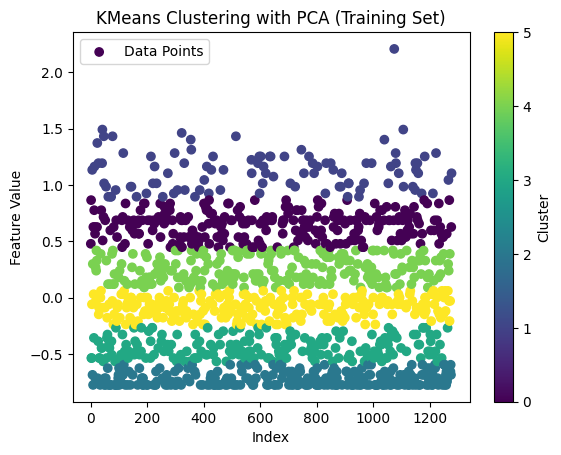

INFO:botocore.credentials:Found credentials in environment variables.
INFO:__main__:Scatter plot successfully logged


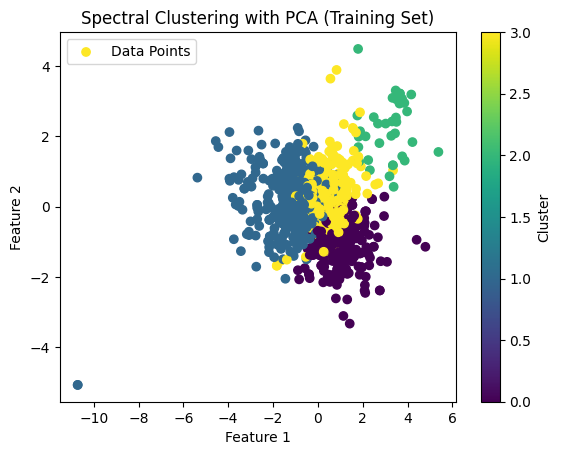

INFO:__main__:Scatter plot successfully logged


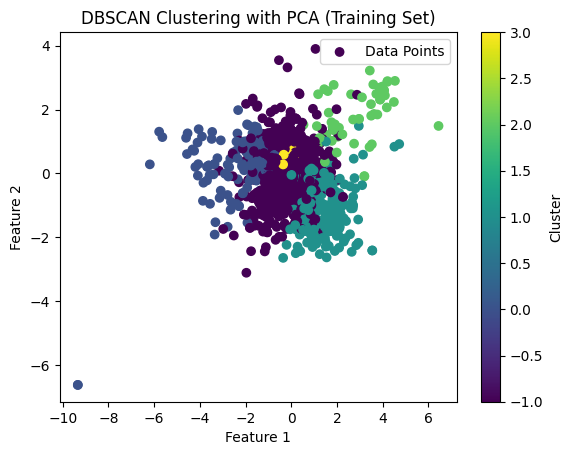

INFO:__main__:Scatter plot successfully logged


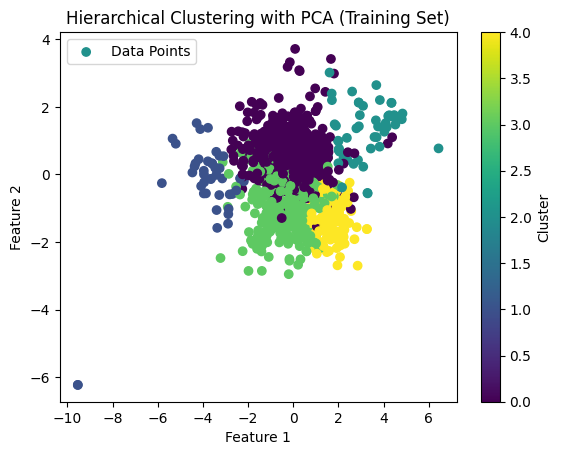

INFO:__main__:Scatter plot successfully logged


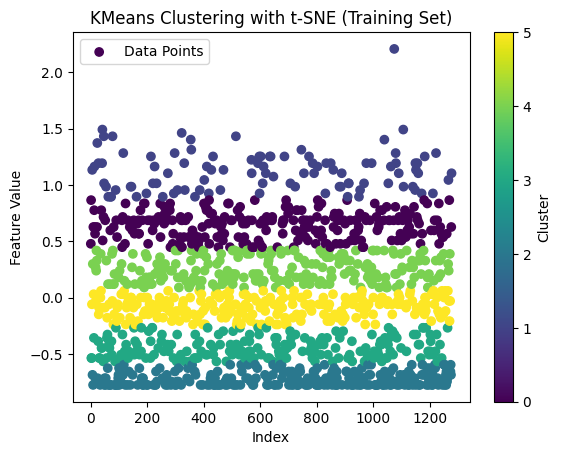

INFO:__main__:Scatter plot successfully logged


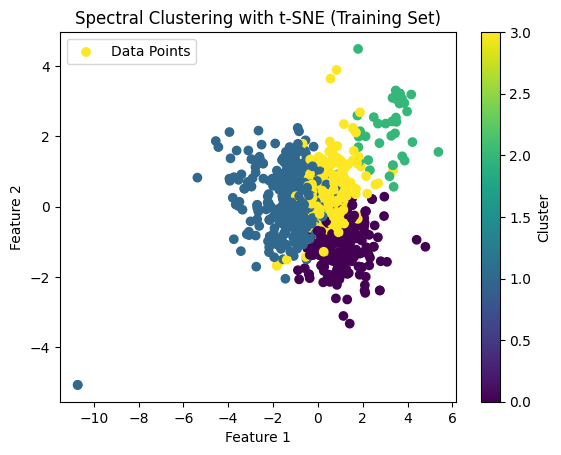

INFO:__main__:Scatter plot successfully logged


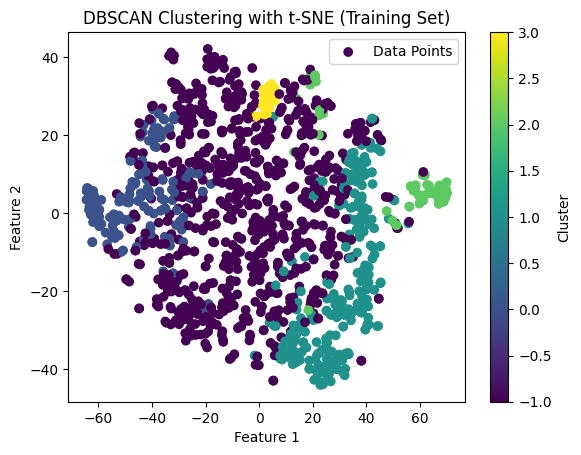

INFO:__main__:Scatter plot successfully logged


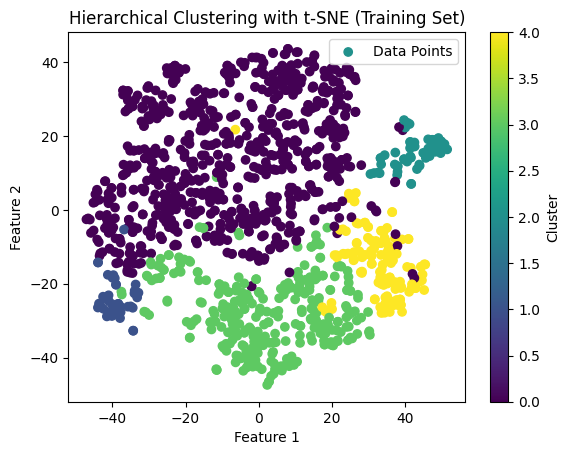

INFO:__main__:Scatter plot successfully logged


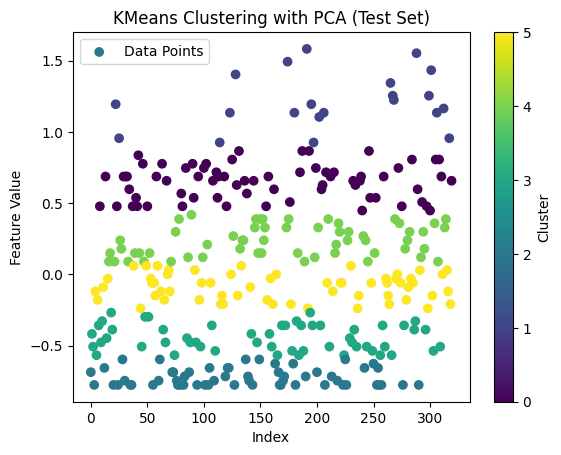

INFO:__main__:Scatter plot successfully logged


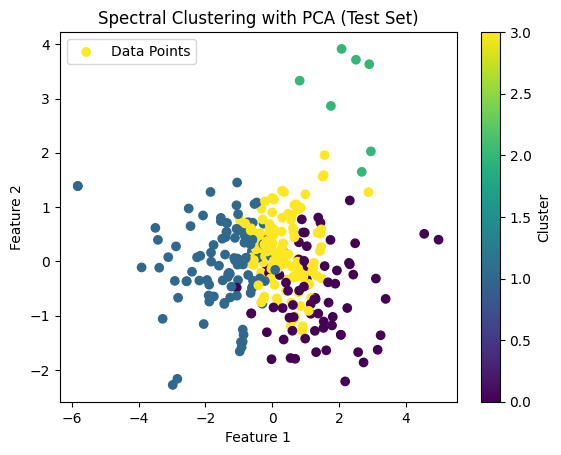

INFO:__main__:Scatter plot successfully logged


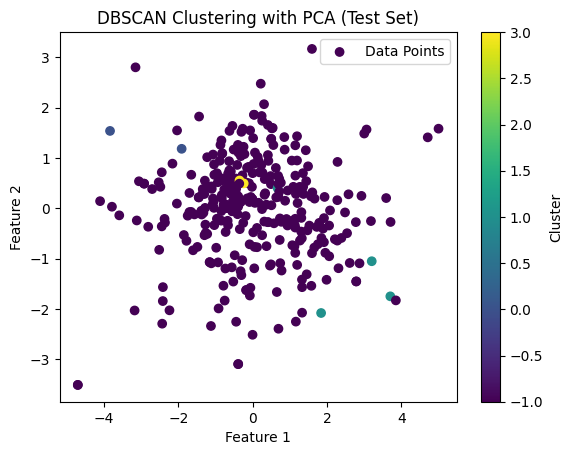

INFO:__main__:Scatter plot successfully logged


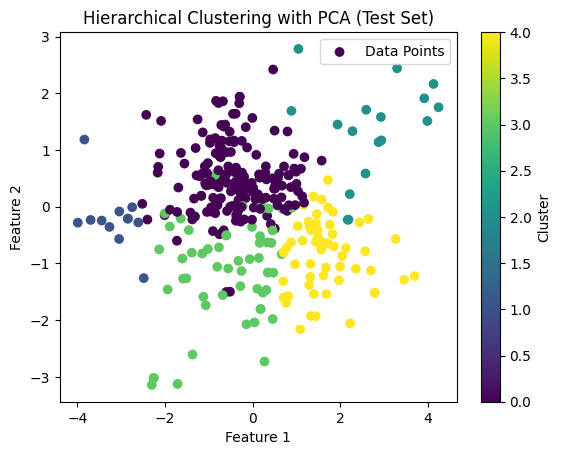

INFO:__main__:Scatter plot successfully logged


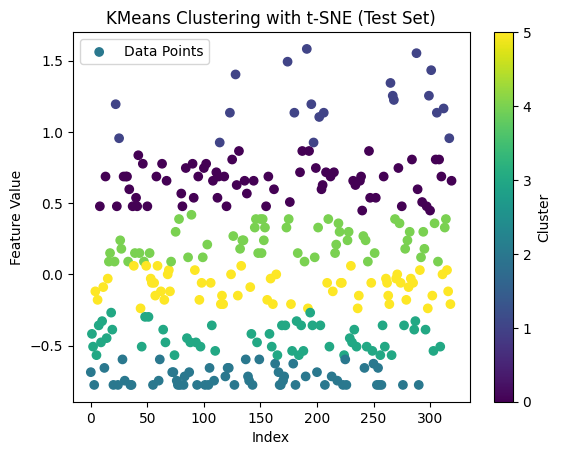

INFO:__main__:Scatter plot successfully logged


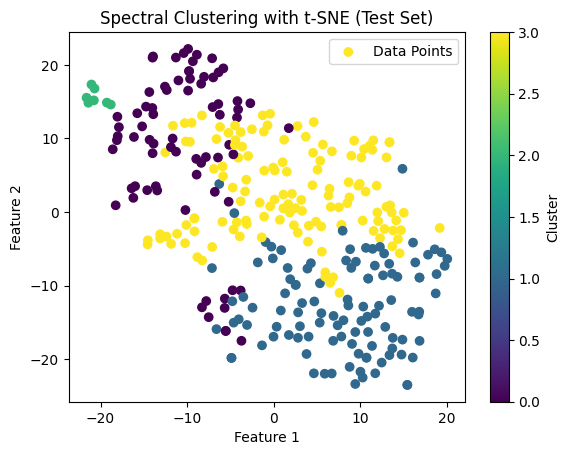

INFO:__main__:Scatter plot successfully logged


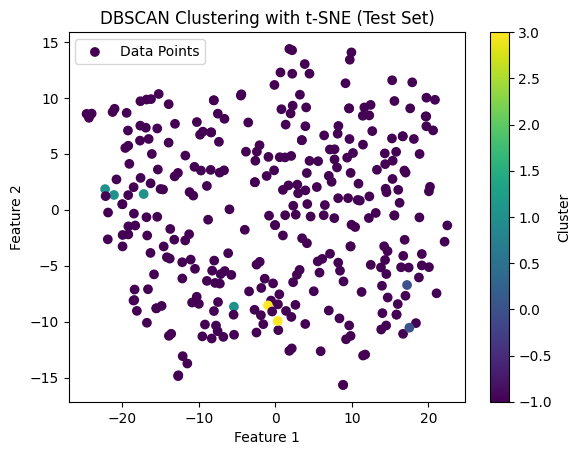

INFO:__main__:Scatter plot successfully logged


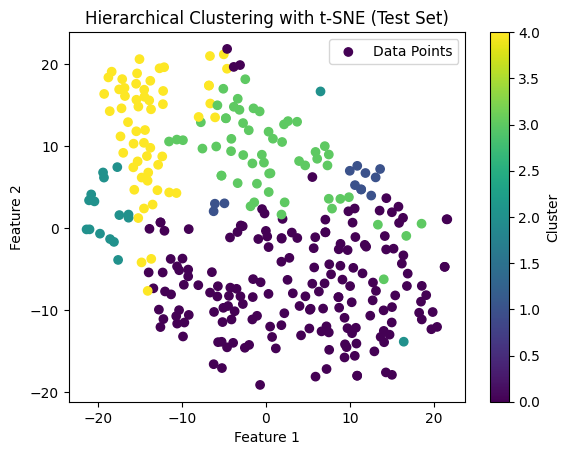

INFO:__main__:Scatter plot successfully logged


🏃 View run Model Evaluation Operation Run at: http://0.0.0.0:5003/#/experiments/2/runs/ae1d726ff33340bf9510ea53267f033d
🧪 View experiment at: http://0.0.0.0:5003/#/experiments/2


IsADirectoryError: [Errno 21] Is a directory: '/Users/josephobukofe/Downloads/user_profile_segmentation/user_profile_segmentation/data/plots'

<Figure size 640x480 with 0 Axes>

In [7]:
training_clustering = {
    "KMeans Clusterer": kmeans_train_clusters,
    "Spectral Clusterer": spectral_train_clusters,
    "DBSCAN Clusterer": dbscan_train_clusters,
    "Hierarchical Clusterer": hierarchical_train_clusters,
}

test_clustering = {
    "KMeans Clusterer": kmeans_test_clusters,
    "Spectral Clusterer": spectral_test_clusters,
    "DBSCAN Clusterer": dbscan_test_clusters,
    "Hierarchical Clusterer": hierarchical_test_clusters,
}

X_train_dict = {
    "KMeans Clusterer": X_train_kmeans_optimal,
    "Spectral Clusterer": X_train_spectral_optimal,
    "DBSCAN Clusterer": X_train_dbscan_optimal,
    "Hierarchical Clusterer": X_train_hierarchical_optimal,
}

X_test_dict = {
    "KMeans Clusterer": X_test_kmeans_optimal,
    "Spectral Clusterer": X_test_spectral_optimal,
    "DBSCAN Clusterer": X_test_dbscan_optimal,
    "Hierarchical Clusterer": X_test_hierarchical_optimal,
}

with mlflow.start_run(run_name="Model Evaluation Operation Run"):
    for model_name in training_clustering.keys():
        train_labels = training_clustering[model_name]
        X_train_optimal = X_train_dict[model_name]

        test_labels = test_clustering[model_name]
        X_test_optimal = X_test_dict[model_name]

        silhouette_train = silhouette_score(X_train_optimal, train_labels)
        davies_bouldin_train = davies_bouldin_score(X_train_optimal, train_labels)
        calinski_harabasz_train = calinski_harabasz_score(X_train_optimal, train_labels)

        silhouette_test = silhouette_score(X_test_optimal, test_labels)
        davies_bouldin_test = davies_bouldin_score(X_test_optimal, test_labels)
        calinski_harabasz_test = calinski_harabasz_score(X_test_optimal, test_labels)

        try:
            mlflow.log_metrics(
                {
                    f"{model_name} - Train Silhouette Score": silhouette_train,
                    f"{model_name} - Train Davies-Bouldin Score": davies_bouldin_train,
                    f"{model_name} - Train Calinski-Harabasz Score": calinski_harabasz_train,
                    f"{model_name} - Test Silhouette Score": silhouette_test,
                    f"{model_name} - Test Davies-Bouldin Score": davies_bouldin_test,
                    f"{model_name} - Test Calinski-Harabasz Score": calinski_harabasz_test,
                }
            )
            logger.info(f"Metrics successfully logged for {model_name}")
        except Exception as e:
            logger.error(f"Error logging metrics: {e}")

    scatter_plot_pca_on_training = {
        "Application": [
            X_train_kmeans_pca,
            X_train_spectral_pca,
            X_train_dbscan_pca,
            X_train_hierarchical_pca,
        ],
        "Clusters": [
            kmeans_train_clusters,
            spectral_train_clusters,
            dbscan_train_clusters,
            hierarchical_train_clusters,
        ],
        "Title": [
            "KMeans Clustering with PCA (Training Set)",
            "Spectral Clustering with PCA (Training Set)",
            "DBSCAN Clustering with PCA (Training Set)",
            "Hierarchical Clustering with PCA (Training Set)",
        ],
    }

    scatter_plot_tsne_on_training = {
        "Application": [
            X_train_kmeans_tsne,
            X_train_spectral_tsne,
            X_train_dbscan_tsne,
            X_train_hierarchical_tsne,
        ],
        "Clusters": [
            kmeans_train_clusters,
            spectral_train_clusters,
            dbscan_train_clusters,
            hierarchical_train_clusters,
        ],
        "Title": [
            "KMeans Clustering with t-SNE (Training Set)",
            "Spectral Clustering with t-SNE (Training Set)",
            "DBSCAN Clustering with t-SNE (Training Set)",
            "Hierarchical Clustering with t-SNE (Training Set)",
        ],
    }

    scatter_plot_pca_on_test = {
        "Application": [
            X_test_kmeans_pca,
            X_test_spectral_pca,
            X_test_dbscan_pca,
            X_test_hierarchical_pca,
        ],
        "Clusters": [
            kmeans_test_clusters,
            spectral_test_clusters,
            dbscan_test_clusters,
            hierarchical_test_clusters,
        ],
        "Title": [
            "KMeans Clustering with PCA (Test Set)",
            "Spectral Clustering with PCA (Test Set)",
            "DBSCAN Clustering with PCA (Test Set)",
            "Hierarchical Clustering with PCA (Test Set)",
        ],
    }

    scatter_plot_tsne_on_test = {
        "Application": [
            X_test_kmeans_tsne,
            X_test_spectral_tsne,
            X_test_dbscan_tsne,
            X_test_hierarchical_tsne,
        ],
        "Clusters": [
            kmeans_test_clusters,
            spectral_test_clusters,
            dbscan_test_clusters,
            hierarchical_test_clusters,
        ],
        "Title": [
            "KMeans Clustering with t-SNE (Test Set)",
            "Spectral Clustering with t-SNE (Test Set)",
            "DBSCAN Clustering with t-SNE (Test Set)",
            "Hierarchical Clustering with t-SNE (Test Set)",
        ],
    }

    for plot in [
        scatter_plot_pca_on_training,
        scatter_plot_tsne_on_training,
        scatter_plot_pca_on_test,
        scatter_plot_tsne_on_test,
    ]:
        for X_reduced, clusters, title in zip(
            plot["Application"],
            plot["Clusters"],
            plot["Title"],
        ):
            scatter_plot(
                X_reduced=X_reduced,
                clusters=clusters,
                title=title,
            )

            scatter_plot_path = f"{title.replace(' ', '_').lower()}.png"
            plt.savefig(scatter_plot_path)

            try:
                mlflow.log_artifact(
                    scatter_plot_path,
                    artifact_path="scatter_plots",
                )
                logger.info("Scatter plot successfully logged")
            except Exception as e:
                logger.error(f"Error logging scatter plot: {e}")

        os.remove(scatter_plot_path)

    model_evaluation_report = evaluate_clustering_models(
        training_clustering=training_clustering,
        test_clustering=test_clustering,
        X_train_dict=X_train_dict,
        X_test_dict=X_test_dict,
    )

    model_evaluation_report_path = MODEL_EVALUATION_REPORT
    model_evaluation_report.to_csv(MODEL_EVALUATION_REPORT, index=False)

    try:
        mlflow.log_artifact(
            model_evaluation_report_path,
            artifact_path="evaluation_reports",
        )
        logger.info("Model evaluation report successfully logged")
    except Exception as e:
        logger.error(f"Error logging model evaluation report: {e}")

    os.remove(model_evaluation_report_path)